In [ ]:
import numpy as np
# from tqdm import tdqm, trange

import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import os
from PIL import Image

from tqdm import tqdm, trange
import torch

import torchvision.transforms as transforms



np.random.seed(0)
torch.manual_seed(0)
print(torch.backends.mps.is_available())
mps_device = torch.device("mps")
print(mps_device)

In [ ]:
import PIL
from PIL import Image
import numpy as np
import os
import random 
import pandas as pd
# open method used to open different extension image file
TRAIN_DATA_FOLDER = "../datasets/MRI/data/mri_data_full/train"
train_tumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/tumor/')
num_train_tumor_files = len(train_tumor_filenames)
print("Number of Training Tumor Files: ", num_train_tumor_files)

train_notumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/notumor/')
num_train_notumor_files = len(train_notumor_filenames)
print("Number of Training No Tumor Files: ", num_train_notumor_files)

## Transformer Model Architecture
![Transformer Model](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

## Resizing Image

### Formula [e.g (N,1,28,28)] 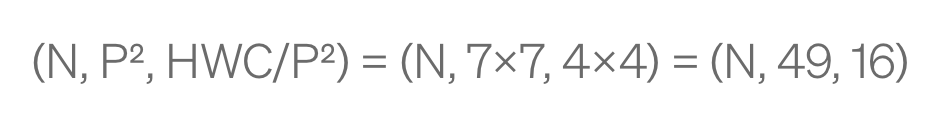
![Reshaping Image](https://miro.medium.com/v2/resize:fit:822/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)


### Positional Embedding
![Positional Embedding Formula](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lpRYHE0XjVkxRVKFrWkzuw.png)

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

def main():

    IMAGE_SIZE = (1,128,128)
    NUM_PATCHES = 32

    train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
    train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=128)

    test_dataset = MRIDataset('../datasets/MRI/test/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
    test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=128)

    # Get one batch (single image and label)
    for images, labels in train_loader:
        # Extract the first image and label
        image = images[0]  # Tensor shape: (C, H, W)
        label = labels[0]
        
        if label == 1:
            # Convert the tensor back to a PIL image for display
            to_pil = ToPILImage()
            image_pil = to_pil(image)

            # Display the image
            plt.imshow(image_pil)
            plt.title(f"Label: {label}")
            plt.axis('off')
            plt.show()
            break

    for images, labels in train_loader:
        # Extract the first image and label
        image = images[0]  # Tensor shape: (C, H, W)
        label = labels[0]

        if label == 0:
            # Convert the tensor back to a PIL image for display
            to_pil = ToPILImage()
            image_pil = to_pil(image)

            # Display the image
            plt.imshow(image_pil)
            plt.title(f"Label: {label}")
            plt.axis('off')
            plt.show()
            break

    print(train_loader)
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    # print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available else "")
    model = MyViT(IMAGE_SIZE, n_patches=NUM_PATCHES, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

    N_EPOCHS = 5
    LR = 0.005
    
    # Training Loop
    optimizer = Adam(model.parameters(),lr = LR)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS,desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader,desc=f"Epoch{epoch+1} in training", leave=False):
            x,y = batch
            # print(y.shape)
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat,y)
            train_loss += loss.detach().cpu().item()/len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        print(f"Epoch {epoch+1}/{N_EPOCHS} loss: {train_loss:.2f}")

    with torch.no_grad():
        correct,total = 0,0
        test_loss = 0.0
        for batch in tqdm(test_loader,desc="Testing"):
            x,y = batch
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat,y)
            test_loss += loss.detach().cpu().item()/len(test_loader)

            correct += torch.sum(torch.argmax(y_hat,dim=1) == y).detach().cpu()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")




# Multi-Self Attention Class

In [ ]:
from MyViT.ViT import * 
from MyViT.utils import MRIDataset,get_positional_embeddings,patchify

if __name__ == '__main__':
    main()

# Causal AI Implementation


Observing Causal Variational Encoder Behavior


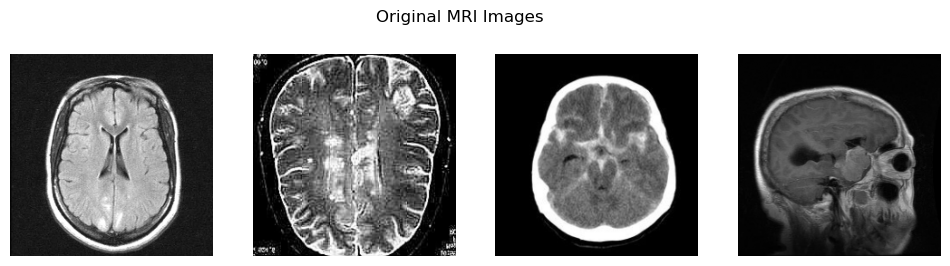

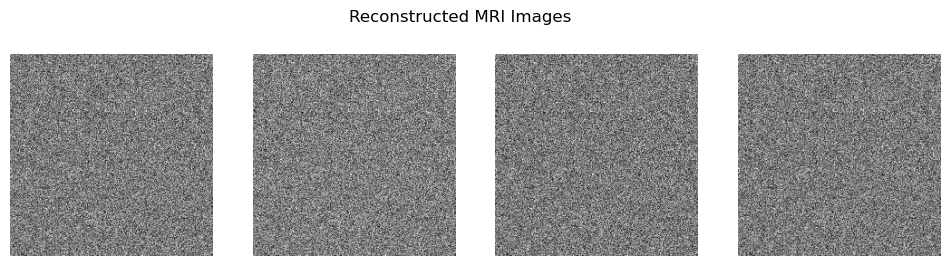

In [24]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from CausalVAE.causal_vae import CausalVAE
from MyViT.utils import MRIDataset  # Assuming MRIDataset is defined in your utils.py

# Assume IMAGE_SIZE is defined somewhere in your code; for example:
# IMAGE_SIZE = (1, 224, 224)  -> grayscale image with height and width of 224 pixels
image_size = 224  # You can set this based on IMAGE_SIZE[1]
input_dim = image_size * image_size  # For grayscale images

# Define the dimensions for the causal VAE
z_dim = 50
hidden_dim = 100

# Instantiate the causal VAE model
model = CausalVAE(input_dim=input_dim, z_dim=z_dim, hidden_dim=hidden_dim)
model.eval()  # Set the model to evaluation mode

# Load your MRI dataset using MRIDataset from utils.py
train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(), image_shape=image_size)
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=128)

# Get a random batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Assuming images are of shape (batch_size, channels, height, width)
# If the images are grayscale, channels=1; we flatten the images for the VAE
batch_size = images.size(0)
images_flat = images.view(batch_size, -1)  # shape: (batch_size, input_dim)

# Pass the images through the causal VAE to obtain reconstructions and latent variables
with torch.no_grad():
    reconstructions, z, z_mu, z_logvar = model(images_flat)

# Helper function to display images
def show_images(imgs, title, image_shape=(image_size, image_size), n=4):
    # Only use the first n images
    imgs = imgs[:n]
    imgs = imgs.view(-1, *image_shape).cpu()
    batch = imgs.size(0)
    fig, axes = plt.subplots(1, batch, figsize=(3 * batch, 3))
    for i in range(batch):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize the original and reconstructed images
show_images(images_flat, "Original MRI Images", image_shape=(image_size, image_size))
show_images(reconstructions, "Reconstructed MRI Images", image_shape=(image_size, image_size))

In [1]:
import torch
from CausalTransformer.causal_transformer import HybridModel
if __name__ == "__main__":
    # Define parameters for MyViT
    vit_params = {
        'chw': (1, 224, 224),  # For example, grayscale images of 224x224
        'n_patches': 8,
        'n_blocks': 2,
        'hidden_d': 64,        # Increased hidden dimension for better representation
        'n_heads': 2,
        'out_d': 10            # This is not used in the hybrid model since we fuse later
    }
    # For the VAE, if using raw images of 224x224:
    vae_input_dim = 224 * 224

    # Instantiate the hybrid model
    model = HybridModel(vit_params, vae_input_dim, vae_z_dim=50, vae_hidden_dim=400, num_classes=2)
    # Example input: a batch of MRI images (batch_size, channels, height, width)
    dummy_images = torch.randn(4, 1, 224, 224)
    outputs = model(dummy_images, return_all=True)
    print("Hybrid Model Output:", outputs)

Hybrid Model Output: (tensor([[0.5237, 0.4763],
        [0.5312, 0.4688],
        [0.4984, 0.5016],
        [0.5813, 0.4187]], grad_fn=<SoftmaxBackward0>), tensor([[0.6679, 0.3995, 0.5907,  ..., 0.5002, 0.7393, 0.4013],
        [0.7188, 0.5127, 0.6106,  ..., 0.4910, 0.6539, 0.3803],
        [0.6217, 0.4020, 0.6606,  ..., 0.5905, 0.7321, 0.5278],
        [0.5218, 0.4639, 0.6077,  ..., 0.5902, 0.6446, 0.3545]],
       grad_fn=<SigmoidBackward0>), tensor([[-1.0723, -0.7470, -0.4442, -0.5101,  0.1686, -0.2381,  0.3620, -0.3890,
         -0.1018,  0.2959, -0.4061, -0.0309,  0.0874,  0.1154, -0.4108, -0.1967,
         -0.5811, -0.4826,  0.0573,  0.3294, -0.1306, -0.6192,  0.1946, -0.4900,
          0.0821,  0.8077,  0.0332, -0.0516,  0.0658,  0.5060,  0.6746, -0.3968,
          0.2609,  0.2068,  0.3489,  0.9569, -0.3809,  0.7923, -0.3902, -0.1964,
         -0.2672, -0.0663,  0.7810,  0.3564, -0.2137,  0.5984,  0.0844, -0.4964,
         -0.0526, -0.0572],
        [-0.7294, -0.4296, -0.1493, -

# Step 3: Training, Evaluation, and Analysis

1. Define the Loss Functions

We have three components in our loss:
	•	Classification Loss: Measures how well the model predicts tumor vs. non-tumor. We’ll use Cross Entropy Loss.
	•	Reconstruction Loss: Measures how close the VAE’s reconstruction is to the original image. For images normalized between 0 and 1, Binary Cross Entropy (BCE) works well.
	•	KL Divergence Loss: Regularizes the latent distribution  z  to be close to a standard normal distribution.

The total loss is given by:


$$
\text{Total Loss} = \text{Classification Loss} + \lambda \times (\text{Reconstruction Loss} + \text{KL Divergence Loss})
$$


where $$\lambda$$ is a hyperparameter controlling the weight of the VAE losses.

In [26]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from MyViT.utils import MRIDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from CausalVAE.causal_vae import CausalVAE
from MyViT.utils import MRIDataset  # Assuming MRIDataset is defined in your utils.py


device = torch.device("cuda" if torch.cuda.is_available() else "mps")
IMAGE_SIZE = (1,64,64)
NUM_PATCHES = 32

train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=128)

test_dataset = MRIDataset('../datasets/MRI/data/test/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=128)

# Hyperparameters
num_epochs = 50  # or more, based on your experiment
lambda_vae = 0.1  # weight for the VAE loss; tune as needed
learning_rate = 1e-3

# Assume train_loader is already defined, for example:
# train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)

# Instantiate the hybrid model (using your parameters)
vit_config = {
    'chw': (1, IMAGE_SIZE[1], IMAGE_SIZE[1]),
    'n_patches': 8,
    'n_blocks': 2,
    'hidden_d': 64,
    'n_heads': 2,
    'out_d': 10  # Not used in fusion since we're overriding the final layer.
}
vae_input_dim = IMAGE_SIZE[1] * IMAGE_SIZE[1]  # Assuming grayscale images of 128x128
model = HybridModel(vit_config, vae_input_dim, vae_z_dim=50, vae_hidden_dim=400, num_classes=2)

# Choose an optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Loss functions
classification_loss_fn = torch.nn.CrossEntropyLoss()
# For reconstruction, assuming images are normalized between 0 and 1.
reconstruction_loss_fn = torch.nn.BCELoss(reduction='sum')  

def kl_divergence_loss(z_mu, z_logvar):
    # Compute KL divergence loss for the latent variables
    # Formula: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    return kl_loss

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        images, labels = batch  # images shape: (batch_size, 1, 224, 224)
        optimizer.zero_grad()
        
        # Forward pass: return all outputs to compute the full loss.
        logits, x_recon, z_mu, z_logvar = model(images, return_all=True)
        
        # Classification loss: note that labels should be of type long
        class_loss = classification_loss_fn(logits, labels.long())
        
        # Reconstruction loss: flatten original images for comparison
        batch_size = images.size(0)
        images_flat = images.view(batch_size, -1)
        recon_loss = reconstruction_loss_fn(x_recon, images_flat)
        
        # KL Divergence loss
        kl_loss = kl_divergence_loss(z_mu, z_logvar)
        
        # Total loss: classification loss plus weighted VAE losses
        total_loss = class_loss + lambda_vae * (recon_loss + kl_loss)
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader.dataset):.4f}")

# After training, switch to evaluation mode
model.eval()

Epoch 1/50, Loss: 197.8755
Epoch 2/50, Loss: 174.9449
Epoch 3/50, Loss: 173.9471
Epoch 4/50, Loss: 173.3526
Epoch 5/50, Loss: 171.7744
Epoch 6/50, Loss: 170.7591
Epoch 7/50, Loss: 170.2353
Epoch 8/50, Loss: 169.7772
Epoch 9/50, Loss: 169.3188
Epoch 10/50, Loss: 168.9303
Epoch 11/50, Loss: 168.5380
Epoch 12/50, Loss: 168.0272
Epoch 13/50, Loss: 167.3335
Epoch 14/50, Loss: 166.7934
Epoch 15/50, Loss: 166.4965
Epoch 16/50, Loss: 166.1257
Epoch 17/50, Loss: 165.8041
Epoch 18/50, Loss: 165.5947
Epoch 19/50, Loss: 165.3227
Epoch 20/50, Loss: 165.1220
Epoch 21/50, Loss: 164.8723
Epoch 22/50, Loss: 164.6557
Epoch 23/50, Loss: 164.4765
Epoch 24/50, Loss: 164.2909
Epoch 25/50, Loss: 164.0738
Epoch 26/50, Loss: 163.8347
Epoch 27/50, Loss: 163.6993
Epoch 28/50, Loss: 163.4199
Epoch 29/50, Loss: 163.2132
Epoch 30/50, Loss: 162.9239
Epoch 31/50, Loss: 162.7135
Epoch 32/50, Loss: 162.4804
Epoch 33/50, Loss: 162.2665
Epoch 34/50, Loss: 162.0829
Epoch 35/50, Loss: 161.9198
Epoch 36/50, Loss: 161.7507
E

HybridModel(
  (vit): MyViT(
    (linear_mapper): Linear(in_features=64, out_features=64, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x MyViTBlock(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mhsa): MyMSA(
          (q_mappings): ModuleList(
            (0-1): 2 x Linear(in_features=32, out_features=32, bias=True)
          )
          (k_mappings): ModuleList(
            (0-1): 2 x Linear(in_features=32, out_features=32, bias=True)
          )
          (v_mappings): ModuleList(
            (0-1): 2 x Linear(in_features=32, out_features=32, bias=True)
          )
          (softmax): Softmax(dim=-1)
        )
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=256, out_features=64, bias=True)
        )
      )
    )
    (mlp): Sequential(
      (0): Linear(in

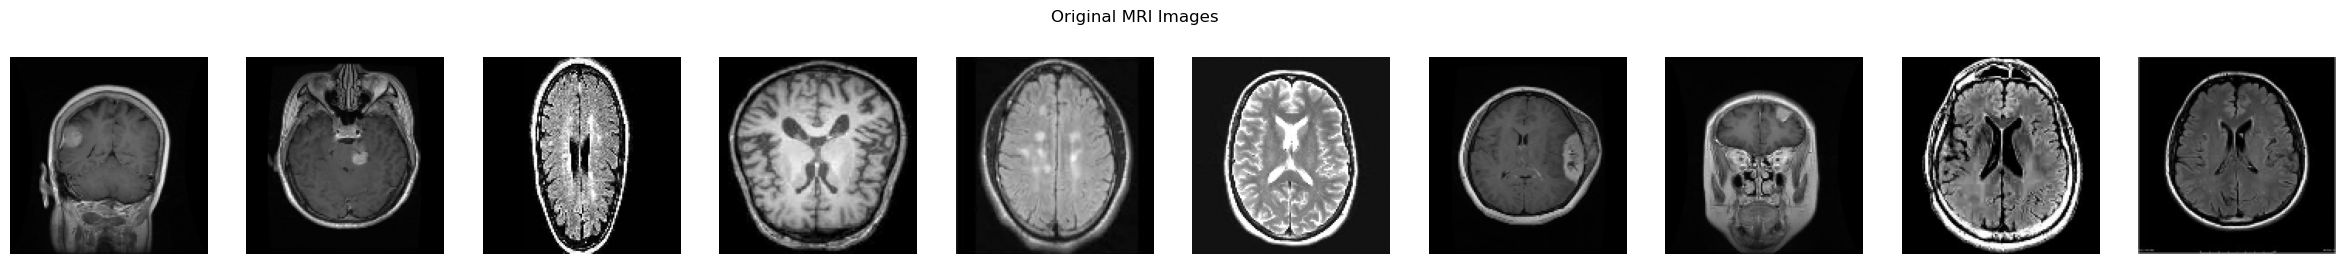

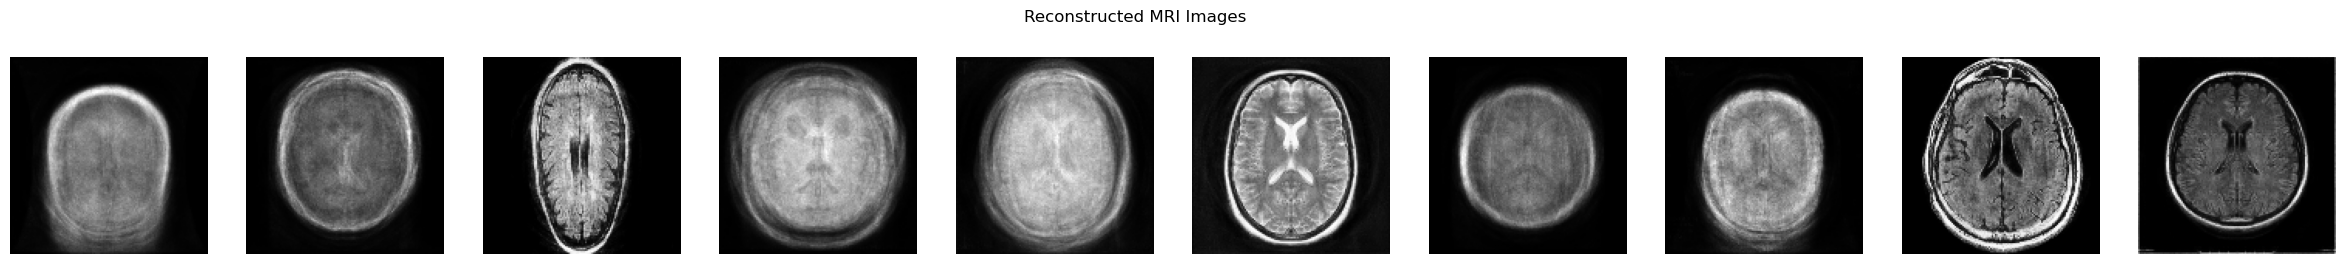

In [ ]:
import matplotlib.pyplot as plt
def show_images(imgs, title, image_shape=(IMAGE_SIZE[1], IMAGE_SIZE[1]), n=10):
    imgs = imgs[:n]
    imgs = imgs.view(-1, *image_shape).cpu()
    batch = imgs.size(0)
    fig, axes = plt.subplots(1, batch, figsize=(3 * batch, 3))
    for i in range(batch):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Get a batch from the validation loader (or train_loader for demonstration)
data_iter = iter(train_loader)
images, _ = next(data_iter)
batch_size = images.size(0)
images_flat = images.view(batch_size, -1)

with torch.no_grad():
    x_recon, _, _, _ = model.causal_vae(images_flat)

# Visualize original vs. reconstructed images
show_images(images_flat, "Original MRI Images", image_shape=(IMAGE_SIZE[1], IMAGE_SIZE[1]), n=10)
show_images(x_recon, "Reconstructed MRI Images", image_shape=(IMAGE_SIZE[1], IMAGE_SIZE[1]), n=10)

Epoch [1/20] | Loss: 198.2060 | Train Acc: 71.54%
Epoch [2/20] | Loss: 174.9235 | Train Acc: 78.53%
Epoch [3/20] | Loss: 173.7927 | Train Acc: 79.04%
Epoch [4/20] | Loss: 172.9375 | Train Acc: 80.74%
Epoch [5/20] | Loss: 171.2512 | Train Acc: 83.23%
Epoch [6/20] | Loss: 170.5403 | Train Acc: 85.34%
Epoch [7/20] | Loss: 170.1222 | Train Acc: 87.80%
Epoch [8/20] | Loss: 169.7218 | Train Acc: 88.51%
Epoch [9/20] | Loss: 169.2393 | Train Acc: 86.33%
Epoch [10/20] | Loss: 168.8568 | Train Acc: 88.17%
Epoch [11/20] | Loss: 168.1987 | Train Acc: 89.37%
Epoch [12/20] | Loss: 167.7213 | Train Acc: 89.71%
Epoch [13/20] | Loss: 167.4621 | Train Acc: 90.59%
Epoch [14/20] | Loss: 167.0541 | Train Acc: 91.10%
Epoch [15/20] | Loss: 166.5772 | Train Acc: 90.46%
Epoch [16/20] | Loss: 166.1655 | Train Acc: 92.16%
Epoch [17/20] | Loss: 165.8075 | Train Acc: 91.04%
Epoch [18/20] | Loss: 165.4983 | Train Acc: 92.81%
Epoch [19/20] | Loss: 165.2735 | Train Acc: 88.48%
Epoch [20/20] | Loss: 164.9961 | Train A

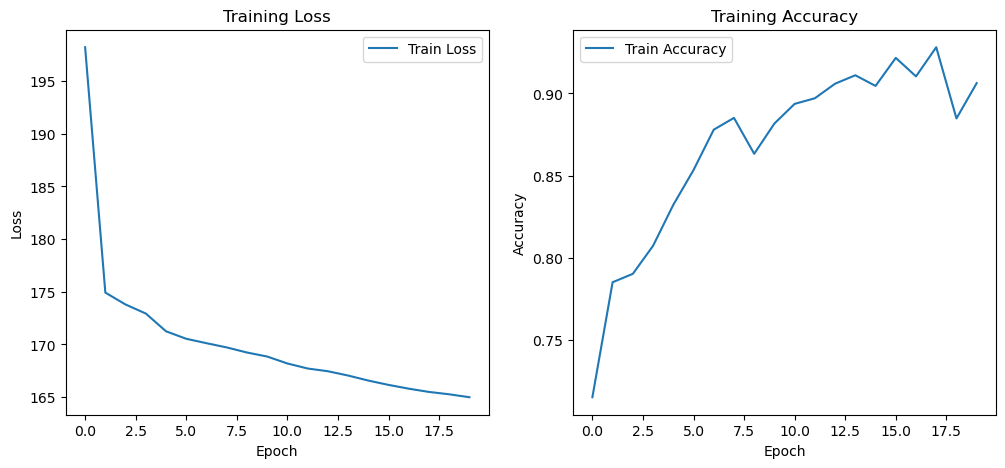

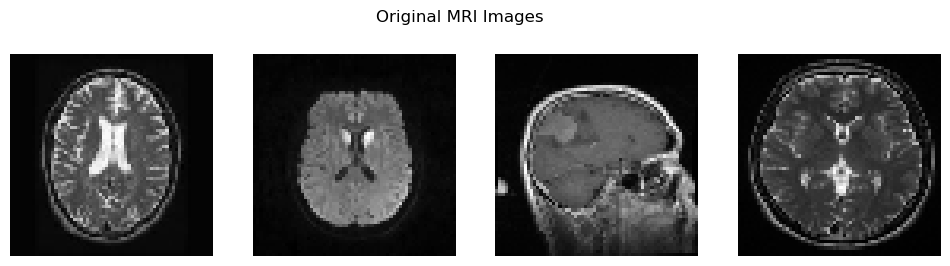

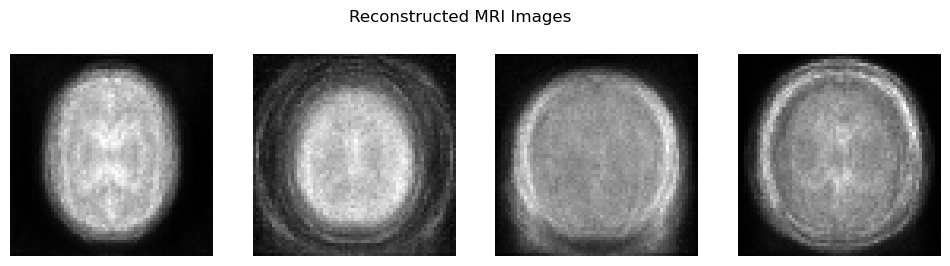

In [29]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# Define the image size constant (e.g., 224 for 224x224 images)
IMAGE_SIZE = 64

# --- Step 1: Define Loss Functions and Hyperparameters ---

classification_loss_fn = torch.nn.CrossEntropyLoss()
reconstruction_loss_fn = torch.nn.BCELoss(reduction='sum')

def kl_divergence_loss(z_mu, z_logvar):
    return -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())

num_epochs = 20
lambda_vae = 0.1
learning_rate = 1e-3

# --- Step 2: Instantiate Your Hybrid Model & Optimizer ---

# Example ViT config using IMAGE_SIZE
vit_config = {
    'chw': (1, IMAGE_SIZE, IMAGE_SIZE),
    'n_patches': 8,
    'n_blocks': 2,
    'hidden_d': 64,
    'n_heads': 2,
    'out_d': 10  # Not used in final classification as we override with fusion_layer
}

vae_input_dim = IMAGE_SIZE * IMAGE_SIZE  # For grayscale images

# Instantiate your HybridModel (assumed to be imported)
model = HybridModel(
    vit_config,
    vae_input_dim=vae_input_dim,
    vae_z_dim=50,
    vae_hidden_dim=400,
    num_classes=2
)

optimizer = Adam(model.parameters(), lr=learning_rate)

# --- Step 3: Define an Accuracy Evaluation Function ---

def evaluate_accuracy(model, data_loader, device='cpu'):
    model.eval()  # set model to evaluation mode
    correct_total = 0
    samples_total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # We only need logits for accuracy
            logits = model(images)  # or model(images, return_all=False)
            _, predicted_classes = torch.max(logits, dim=1)

            correct_total += (predicted_classes == labels).sum().item()
            samples_total += labels.size(0)

    return correct_total / samples_total if samples_total > 0 else 0.0

# --- Step 4: Training Loop with Periodic Accuracy Checks ---

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass, returning VAE outputs for reconstruction & KL losses
        logits, x_recon, z_mu, z_logvar = model(images, return_all=True)

        # Classification Loss
        class_loss = classification_loss_fn(logits, labels.long())

        # Reconstruction Loss: flatten images using IMAGE_SIZE
        batch_size = images.size(0)
        images_flat = images.view(batch_size, -1)
        recon_loss = reconstruction_loss_fn(x_recon, images_flat)

        # KL Divergence Loss
        kl_loss = kl_divergence_loss(z_mu, z_logvar)

        # Combined Loss
        total_loss = class_loss + lambda_vae * (recon_loss + kl_loss)
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Evaluate accuracy on the training set
    train_acc = evaluate_accuracy(model, train_loader)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_epoch_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

# --- Optional: Plot Training Loss and Accuracy ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


# --- Step 5: Visualize Reconstructions Using IMAGE_SIZE ---

def show_images(imgs, title, image_shape=(IMAGE_SIZE, IMAGE_SIZE), n=4):
    imgs = imgs[:n]
    imgs = imgs.view(-1, *image_shape).cpu()
    batch = imgs.size(0)
    fig, axes = plt.subplots(1, batch, figsize=(3 * batch, 3))
    for i in range(batch):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Get a batch from the train_loader for visualization
data_iter = iter(train_loader)
images, _ = next(data_iter)
batch_size = images.size(0)
images_flat = images.view(batch_size, -1)

with torch.no_grad():
    x_recon, _, _, _ = model.causal_vae(images_flat)

show_images(images_flat, "Original MRI Images", image_shape=(IMAGE_SIZE, IMAGE_SIZE), n=4)
show_images(x_recon, "Reconstructed MRI Images", image_shape=(IMAGE_SIZE, IMAGE_SIZE), n=4)